### Fraud detection
A supervised learning approach

In [46]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import classification_report
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import roc_auc_score

from pathlib                 import Path
from imblearn.pipeline       import Pipeline 
from sklearn.ensemble        import RandomForestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import VotingClassifier
from sklearn.tree     import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

In [4]:
# set root directory
path_root = Path("C:/Users/giann/data-science-core")
os.chdir(path_root)
print(f'- Root directory = {os.getcwd()}')

- Root directory = C:\Users\giann\data-science-core


### Data & and detect how imbalanced is the class

In [11]:
path_dataset = path_root / 'dataset/creditcard_sampledata.csv'
data = pd.read_csv(path_dataset, index_col = 0)
X = data.drop('Class', axis = 1).values
y = data['Class'].values
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,0.169360,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,-0.715756,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,0.984938,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,-0.372442,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


In [9]:
print("o Count the occurrences of fraud and no fraud")
occ = data['Class'].value_counts()
print(occ)
print("o Ratio of fraud cases")
print( (occ / len(data['Class'])) *100 )

o Count the occurrences of fraud and no fraud
0    7983
1      17
Name: Class, dtype: int64
o Ratio of fraud cases
0    99.7875
1     0.2125
Name: Class, dtype: float64


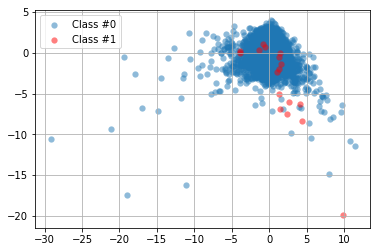

In [14]:
# Plot our data by running our plot data function on X and y
def plot_data(X, y) :
    plt.scatter(X[y == 0, 2], X[y == 0, 3], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 2], X[y == 1, 3], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    plt.grid()

plot_data(X, y)

### Resample with SMOTE to account for imbalancness
NB: resample only on train set

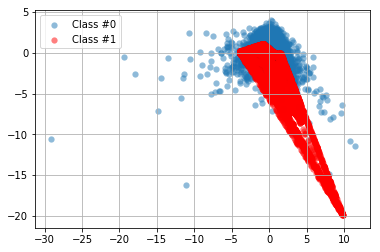

In [16]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

# Define the resampling method
method = SMOTE(sampling_strategy = 'minority')
# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)
# Plot
plot_data(X_resampled, y_resampled)

### Train and evaluate

In [18]:
# Continue fitting the model and obtain predictions
model = LogisticRegression(solver = 'lbfgs')
model.fit(X_resampled, y_resampled)
# Get your performance metrics
predicted = model.predict(X_test)

In [20]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1597
           1       0.03      1.00      0.06         3

   micro avg       0.94      0.94      0.94      1600
   macro avg       0.51      0.97      0.51      1600
weighted avg       1.00      0.94      0.97      1600

Confusion matrix:
 [[1495  102]
 [   0    3]]


### Training with pipeline

In [21]:
# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(sampling_strategy = 'minority')
model      = LogisticRegression(solver = 'lbfgs')
pipeline   = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [22]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      1597
           1       0.03      1.00      0.06         3

   micro avg       0.94      0.94      0.94      1600
   macro avg       0.52      0.97      0.51      1600
weighted avg       1.00      0.94      0.97      1600

Confusion matrix:
 [[1503   94]
 [   0    3]]


## Ensemble method

In [23]:
# Load data
path_dataset = path_root / 'dataset/creditcard_sampledata_2.csv'
data = pd.read_csv(path_dataset, index_col = 0)
X = data.drop('Class', axis = 1).values
y = data['Class'].values
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,...,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,...,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,...,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,...,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,...,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [25]:
# Evaluate 'natural accuracy' to use as baseline 
total_obs = len(y)
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100
# Print the percentage: this is our "natural accuracy" by doing nothing
print(f"Natural accuracy = {round(percentage, 2)} %" )

Natural accuracy = 95.89 %


### Train with Random forest

In [28]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Define the model as the random forest
model = RandomForestClassifier(random_state = 5, n_estimators = 10)
# Fit the model to our training set
model.fit(X_train, y_train)
# Obtain predictions from the test data 
predicted = model.predict(X_test)
# Predict probabilities
probs = model.predict_proba(X_test)

In [32]:
# Print performance metric
print(f"o Random Forest accuracy = {round(accuracy_score(y_test, predicted) * 100, 2)} %")
print(f"o AUC score = {round(roc_auc_score(y_test, probs[:,1]) * 100, 2)} %")
print("o Classification report")
print(classification_report(y_test, predicted))
print("o Confusion matrix")
print(confusion_matrix(y_test, predicted))

o Random Forest accuracy = 99.09 %
o AUC score = 93.98 %
o Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

o Confusion matrix
[[2097    2]
 [  18   73]]


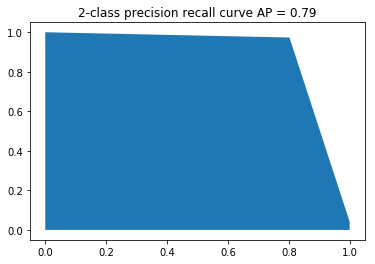

In [33]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)
# Plot the recall precision tradeoff
plt.fill_between(recall, precision)
plt.title(f'2-class precision recall curve AP = {round(average_precision,2)}')
plt.show()

**NB**: AUCROC says how well can this classifier be expected to perform in general, at a variety of different baseline probabilities?" but precision and recall don't.

### Model Tuning

**OPTION 1**: Define the model with `balanced_subsample`

In [39]:
model = RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 5, n_estimators = 100)
# Fit your training model to your training set
model.fit(X_train, y_train)
# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)
# Print the roc_auc_score, the classification report and confusion matrix
print(f"o AUC score = {round(roc_auc_score(y_test, probs[:,1]) * 100 , 2)} %")
print(classification_report(y_test, predicted))
print("o Confusion_matrix")
print(confusion_matrix(y_test, predicted))

o AUC score = 96.7 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

o Confusion_matrix
[[2098    1]
 [  18   73]]


**OPTION2**: using `GridSearchCV`

In [40]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 
              'max_features': ['auto', 'log2'],  
              'max_depth'   : [4, 8] , 
              'criterion'   : ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state = 5, n_estimators = 100)
# Combine the parameter sets with the defined model: Optimize per Recall 'minimize false negative'
CV_model = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'recall', n_jobs = -1)

In [41]:
# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
# show best parameters
CV_model.best_params_
# get best model
bestRF    = CV_model.best_estimator_
predicted = bestRF.predict(X_test)
probs     = bestRF.predict_proba(X_test)

In [45]:
print(f"o AUC score = {round(roc_auc_score(y_test, probs[:,1]) * 100, 2)} %")
print(classification_report(y_test, predicted))
print("o Confusion matrix")
print(confusion_matrix(y_test, predicted))

o AUC score = 96.08 %
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

o Confusion matrix
[[2098    1]
 [  18   73]]


### Ensemble methods
Let's now combine three machine learning models into one, to improve our 

In [53]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, solver = 'lbfgs', max_iter = 1000)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
                              min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

In [56]:
# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')
ensemble_model.fit(X_train, y_train)
predicted = ensemble_model.predict(X_test)
#probs     = ensemble_model.predict_proba(X_test)

In [58]:
# Get the results 
#print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.89      0.86      0.87        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.94      0.93      0.93      2190
weighted avg       0.99      0.99      0.99      2190

[[2089   10]
 [  13   78]]


### Adjust Weights
You've just seen that the Voting Classifier allows you to improve your fraud detection performance, by combining good aspects from multiple models. Now let's try to adjust the weights we give to these models. By increasing or decreasing weights you can play with how much emphasis you give to a particular model relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.

In [59]:
# Define the ensemble model: weight more Random Forest
ensemble_model = VotingClassifier(estimators = [('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
                                  voting     = 'soft', 
                                  weights    = [1, 4, 1], 
                                  flatten_transform = True)

ensemble_model.fit(X_train, y_train)
predicted = ensemble_model.predict(X_test)
probs     = ensemble_model.predict_proba(X_test)

In [60]:
# Get the results 
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.970744834013057
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.86      0.90        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.97      0.93      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2094    5]
 [  13   78]]
